In [183]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Loading data
data = pd.read_csv("../data/cleaned_data.csv")

# Converting date column to datetime
data["Date"] = pd.to_datetime(data["Date"])

# Ignoring the UserWarning raised by the above line. The warning raised tells me that not setting a specific format or handing errors could be problematic, but further
# examination of the Date column showed that it is not, so I am hiding the warning from printing
warnings.simplefilter(action = "ignore", category = UserWarning)
data.head(2)

,Date,About,Period,Player Load Per Minute,IMA Accel Low,IMA Accel High,IMA Accel Total,IMA Jump Count Low Band,IMA Jump Count Med Band,IMA Jump Count High Band,Season,Prop_Accel_High,Prop_Jump_High
0,2022-11-07,Athlete A,Game,9.5,21,4,36,16,6,9,1,0.111111,0.290323
1,2022-11-07,Athlete C,Game,8.4,20,3,32,29,14,6,1,0.093750,0.122449


In [184]:
data = data[data["About"] != "Ben Vander Plas"]

In [185]:
# This code chunk retrieves the n-game (7-game) rolling average of proportion of high-band accelerations and jumps

# Empty list to hold rolling_averages data
rolling_averages = []

# Variable for number of games in rolling average
window = 7

# Looping through each group of the df, where the groups are by player
for player, group in data.groupby("About"):
    # Ensuring the dates are in the correct order for the rolling average calculation
    group = group.sort_values(by = "Date")

    # Calculating the rolling averages, over window games, and assigning that to the new column made for that value
    group["Prop_Accel_High"] = group["Prop_Accel_High"].rolling(window, min_periods = 1).mean()
    group["Prop_Jump_High"]= group["Prop_Jump_High"].rolling(window, min_periods = 1).mean()

    # Appending the group to the list of groups to be put in a df later
    rolling_averages.append(group)

# Concatenating the rolling average groups. Each player/group is essentially a row in this new dataframe
rolling_df = pd.concat(rolling_averages)

# Filtering out players who have played less than 20 games, as our analysis requires a pretty large sample size

# Getting game count by player
player_games = rolling_df["About"].value_counts()
# Getting the players who have played more than 5 games
players_met_min_games = player_games[player_games >= 15].index
# Limiting rolling_df to only players in the list of players who have played 5 games
rolling_df = rolling_df[rolling_df["About"].isin(players_met_min_games)]
print(len(rolling_df["About"].unique()))

15


In [186]:
# Getting the number of seasons per player, and getting a list of players who are in both seasons
players_seasons = rolling_df.groupby('About')['Season'].nunique()
players_in_both = players_seasons[players_seasons > 1].index.tolist()

# Getting list of all players
players = rolling_df['About'].unique()

# Making a palette where players in 1 season are orange, and players in 2 seasons are navy
palette = {player : ('navy' if player in players_in_both else 'orange') for player in players}

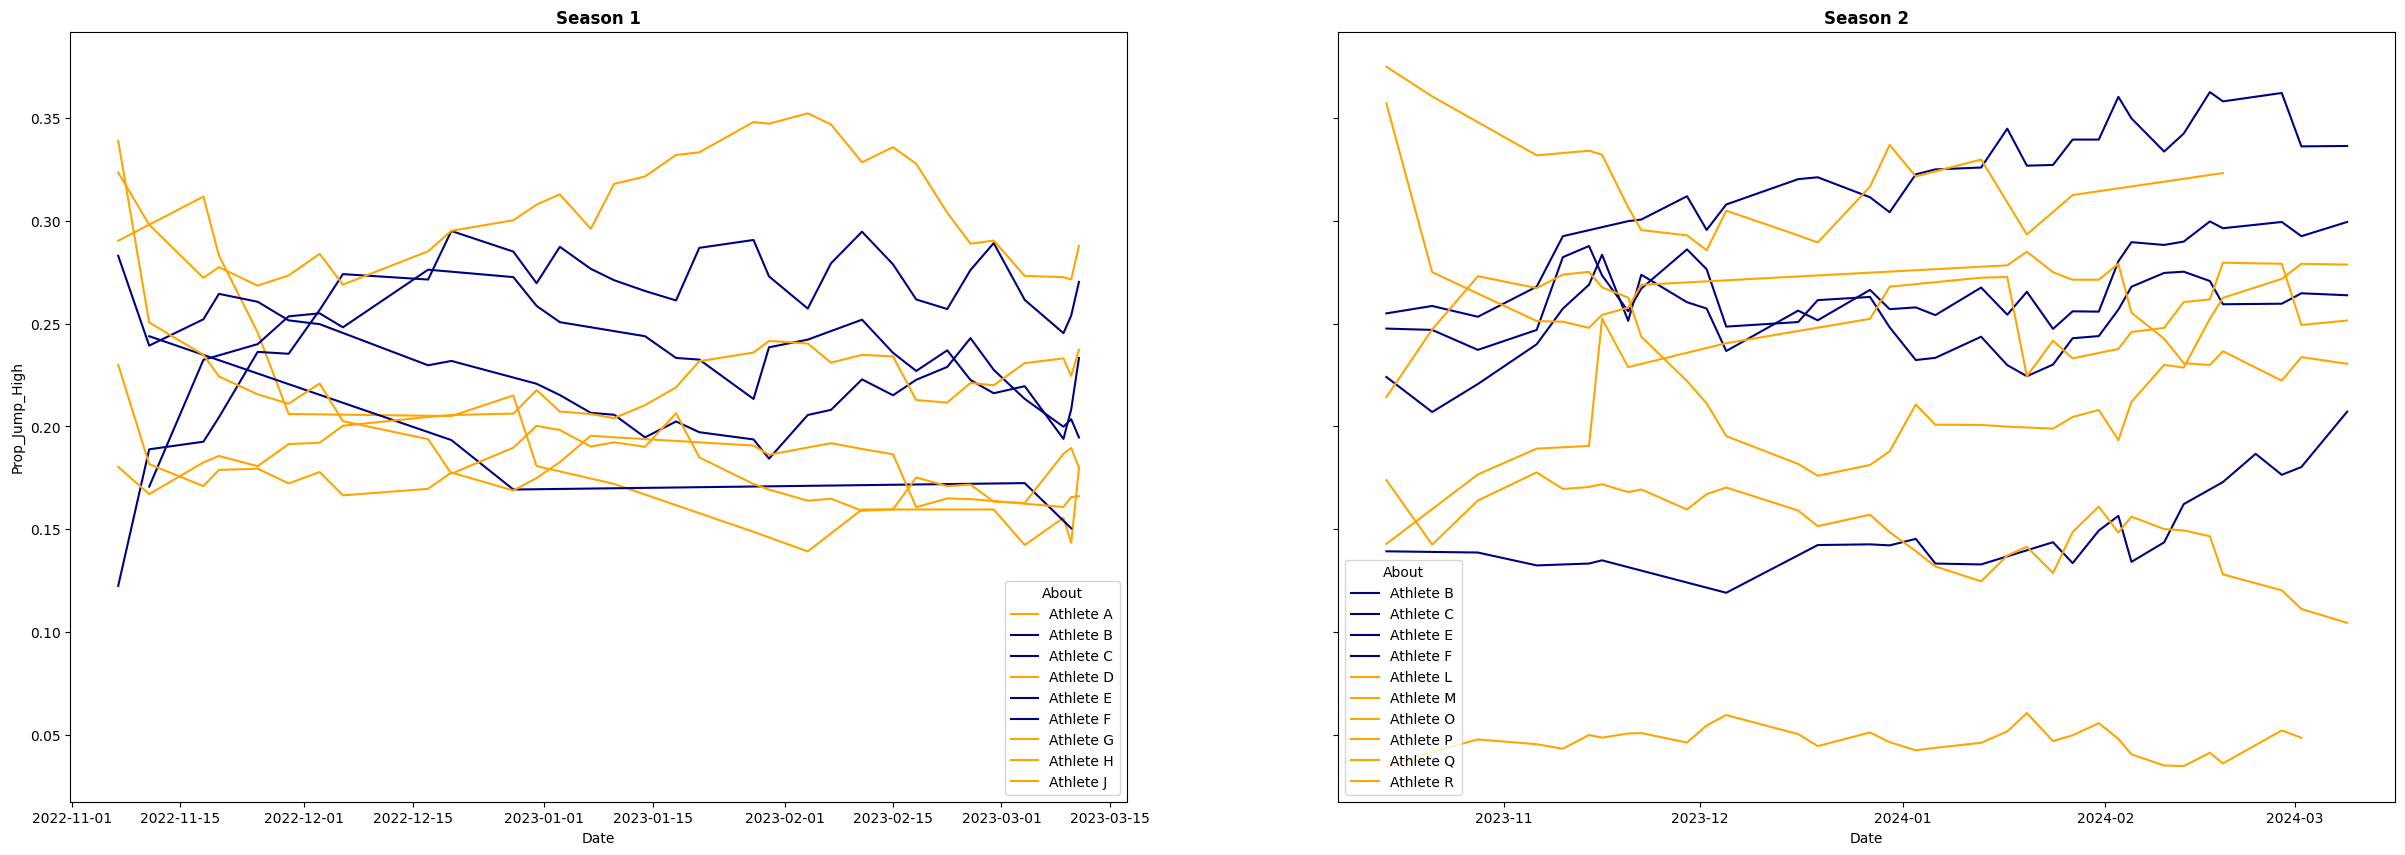

In [187]:
# Creating Figure and Flattening Axes
fig, axs = plt.subplots(1, 2, figsize = (30, 10), sharey = True)
axs = axs.flatten()

# Looping through subplots and seasons
for ax, season in zip(axs, [1, 2]):
    # Making plot of proportion of jumps in high band by player, for each season
    sns.lineplot(data = rolling_df[rolling_df["Season"] == season], x = 'Date', y = "Prop_Jump_High", hue = "About", palette = palette, ax = ax)
    ax.set_title(f"Season {season}", weight = 'bold')

# Showing plots
plt.show()

{1: Timestamp('2022-11-07 00:00:00'), 2: Timestamp('2023-10-14 00:00:00')}
   Player_Group     Slope  Intercept   R-value
0  both_seasons  0.000110   0.230065  0.391916
1    one_season -0.000136   0.216189 -0.268255


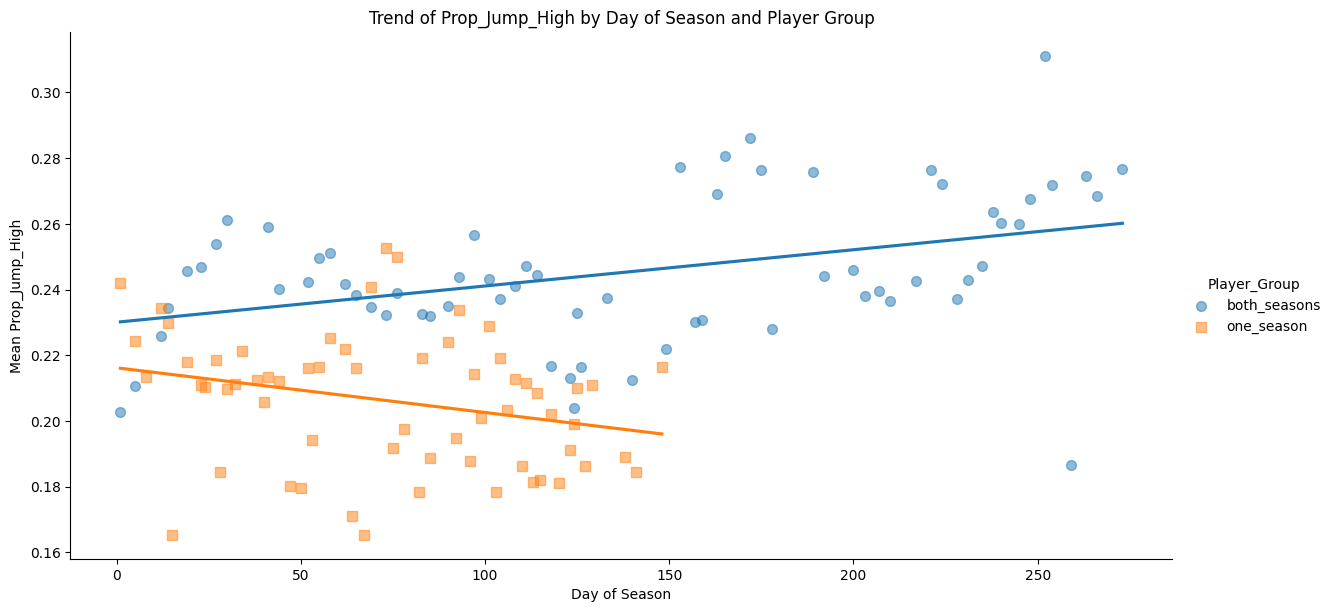

In [ ]:
# Making a new variable which tells whether or not the player is in both seasons or just one
rolling_df['Player_Group'] = rolling_df['About'].apply(lambda x: 'both_seasons' if x in players_in_both else 'one_season')


# Getting the start date for each season
season_starts = rolling_df.groupby('Season')['Date'].min().to_dict()

# Getting the number of days into the season for each season
rolling_df['Day_of_Season'] = rolling_df.apply(lambda row: (row['Date'] - season_starts[row['Season']]).days + 1, axis=1)

# Getting last day of season 1
season1_length = (rolling_df[rolling_df['Season'] == 1]['Date'].max() - season_starts[1]).days + 1

# Function adds the number of days in the first season to the day in the second season
    # This prevents for example the 5th day in the second season and the 5th day in the first season being seen as the same day
def adjust_day(row):
    if row['Player_Group'] == 'both_seasons' and row['Season'] == 2:
        return row['Day_of_Season'] + season1_length
    else:
        return row['Day_of_Season']

# Adding the first season length to the second seasons
rolling_df['Adjusted_Day'] = rolling_df.apply(adjust_day, axis=1)

# Grouping by day of the season and whether or not the player was in both seasons, then taking the mean of the prop
daily_means = rolling_df.groupby(['Adjusted_Day', 'Player_Group'])['Prop_Jump_High'].mean().reset_index()

from scipy import stats

# Making a dataframe to hold the required linear regression values
linreg_df = pd.DataFrame(columns=["Player_Group", "Slope", "Intercept", "R-value"])

# Looping through each unique player group (instead of dataset in the original code)
for group in daily_means["Player_Group"].unique():
    # Selecting the relevant data for the current player group
    group_data = daily_means[daily_means["Player_Group"] == group]
    
    # Running linear regression on Adjusted_Day vs Prop_Jump_High
    slope, intercept, r_value, p_value, std_err = stats.linregress(group_data['Adjusted_Day'], group_data['Prop_Jump_High'])
    
    # Adding the linear regression results to the DataFrame
    linreg_df.loc[len(linreg_df)] = [group, slope, intercept, r_value]

# Showing the table with linear regression results
print(linreg_df)



sns.lmplot(
    data=daily_means,
    x='Adjusted_Day',
    y='Prop_Jump_High',
    hue='Player_Group',
    ci=None,   # Remove confidence intervals (optional)
    markers=["o", "s"],
    scatter_kws={"s": 50, "alpha": 0.5},  # smaller, lighter scatter points
    height=6,
    aspect=2
)

plt.title('Trend of Prop_Jump_High by Day of Season and Player Group')
plt.xlabel('Day of Season')
plt.ylabel('Mean Prop_Jump_High')
plt.show()
